In [3]:
import silence_tensorflow.auto
from typing import Dict, List
import numpy as np
import pandas as pd
from ensmallen_graph import EnsmallenGraph
from extra_keras_metrics import get_minimal_multiclass_metrics
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
from embiggen import GraphVisualization
from embiggen.utils import compute_node_embedding
from plot_keras_history import plot_history
from tqdm.auto import tqdm

from keras_ding import Ding

## Loading the graph

In [4]:
from ensmallen_graph.datasets.linqs import Cora, CiteSeer, PubMedDiabetes

complete_graph = Cora()
graph = complete_graph.remove(deny_node_types_set=set(["Word"]))

graph.enable(
    vector_destinations=True,
    vector_outbounds=True
)

In [5]:
def get_words_data(graph: EnsmallenGraph):
    word_node_type = graph.get_node_type_names().index("Word")
    weights = graph.get_weights() if graph.has_weights() else None
    return pd.DataFrame({
        node_name: {
            graph.get_node_name(source): weights[graph.get_edge_id(source, node_id)] if graph.has_weights() else 1
            for source in graph.get_filtered_neighbours(node_id)
        }
        for node_id, node_name in enumerate(tqdm(graph.get_node_names(), desc="Extracting words features"))
        if graph.get_node_type(node_id) == word_node_type
    }).fillna(0)
words_features = get_words_data(complete_graph)
words_features

Extracting words features:   0%|          | 0/4141 [00:00<?, ?it/s]

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_1423,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432
1153728,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
950052,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1152858,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1114502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
362926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
628667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
graph

The undirected graph Cora has 2708 nodes with 7 different node types:  the 5 most common are Neural_Networks (nodes number 818), Probabilistic_Methods (nodes number 426), Genetic_Algorithms (nodes number 418), Theory (nodes number 351) and Case_Based (nodes number 298) and 5278 unweighted edges with a single edge type: Paper2Paper, of which none are self-loops. The graph is sparse as it has a density of 0.00144 and has 78 connected components, where the component with most nodes has 2485 nodes and the component with the least nodes has 2 nodes. The graph median node degree is 3, the mean node degree is 3.90, and the node degree mode is 2. The top 5 most central nodes are 35 (degree 168), 6213 (degree 78), 1365 (degree 74), 3229 (degree 65) and 910 (degree 44). The hash of the graph is a330cf2cdce2409d .

## Preparing the data for node-label prediction

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

def build_training_sequences(
    graph: EnsmallenGraph,
    test_size: float = 0.2,
    random_state: int = 42
):
    y = graph.get_node_types()
    mask = np.ones_like(y, dtype=bool)
    for target in ("Word", "Unknown"):
        if target in graph.get_node_type_names():
            mask = y!=list(graph.get_node_type_names()).index(target)
    
    y = y[mask]
    X = np.arange(graph.get_nodes_number())[mask]
    encoder = OneHotEncoder(sparse=False)
    y = encoder.fit_transform(y.reshape(-1, 1))
    splitter = StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=test_size)
    train_indices, test_indices = next(splitter.split(X, y))
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = build_training_sequences(graph)

## Computing the node embedding

In [8]:
node_embedding = compute_node_embedding(
    graph,
    node_embedding_method_name="SkipGram",
    explore_weight=10.0,
    return_weight=0.01,
)
node_embedding.index = node_embedding.index.astype(str)

## Visualizing the node embedding

In [9]:
combined = pd.concat(
    (
        node_embedding,
        words_features,
        #pd.DataFrame((graph.degrees()), index=node_embedding.index)
    ),
    axis=1
)

from sklearn.preprocessing import RobustScaler

scaled = RobustScaler().fit_transform(combined)
scaled = pd.DataFrame(scaled, index=node_embedding.index)

In [10]:
visualization = GraphVisualization(graph, node_embedding_method="SkipGram")
visualization.fit_transform_nodes(scaled)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:title={'center':'Node degrees - Cora - SkipGram'}>)

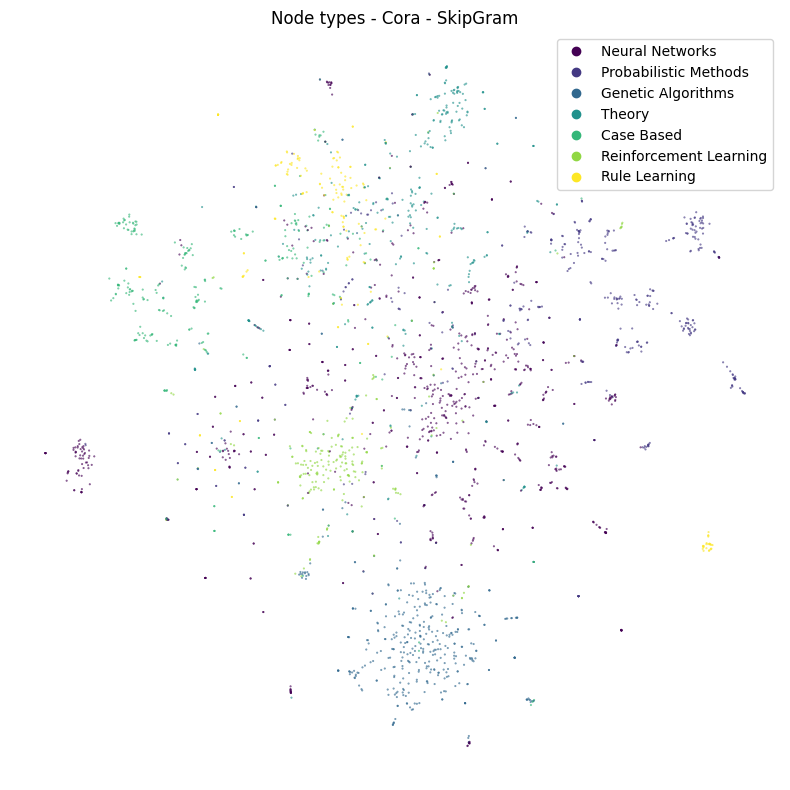

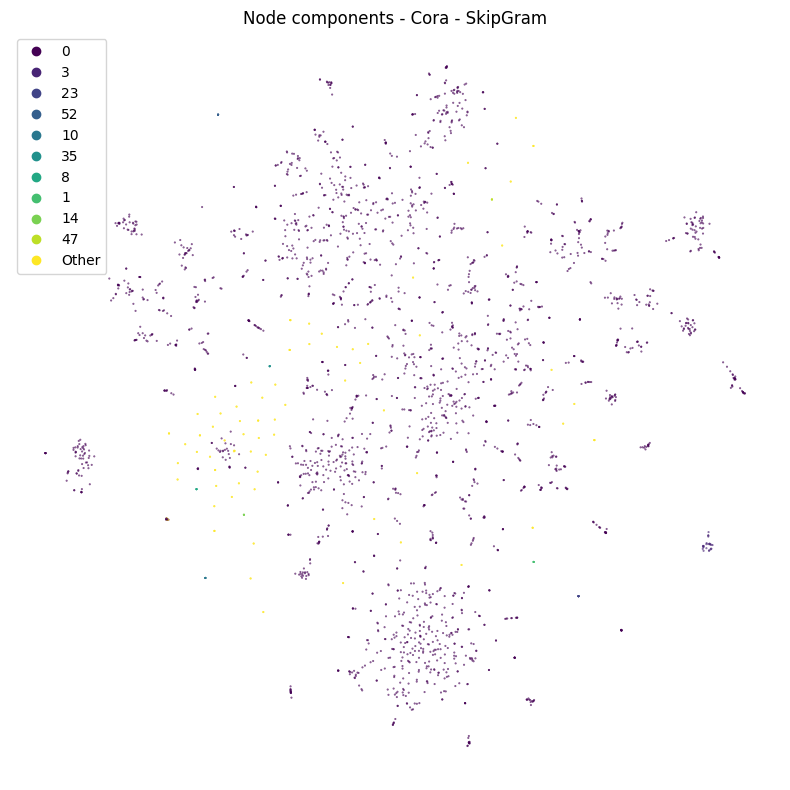

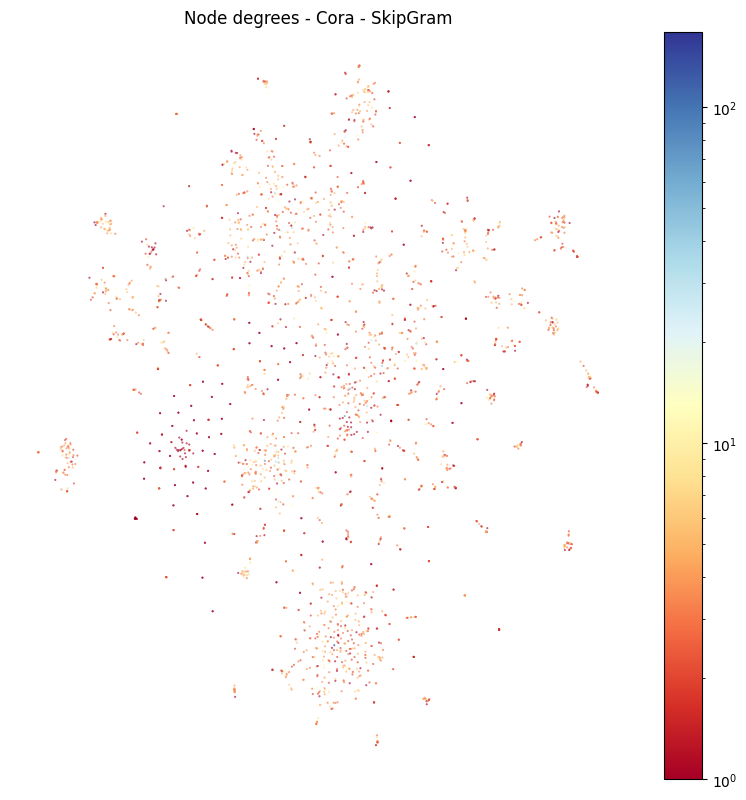

In [11]:
visualization.plot_node_types()
visualization.plot_connected_components()
visualization.plot_node_degrees()

In [12]:
"""Keras Sequence for running Neural Network on graph node-label embedding."""
from typing import Tuple

import numpy as np
from ensmallen_graph import EnsmallenGraph
from keras_mixed_sequence import VectorSequence


class NodeLabelNeighboursSequence(VectorSequence):
    """Keras Sequence for running Neural Network on graph node-label prediction."""

    def __init__(
        self,
        graph: EnsmallenGraph,
        node_ids: np.ndarray,
        max_neighbours: int = None,
        include_central_node: bool = True,
        batch_size: int = 2**8,
        elapsed_epochs: int = 0,
        random_state: int = 42,
        support_mirror_strategy: bool = False
    ):
        """Create new LinkPredictionSequence object.

        Parameters
        --------------------------------
        graph: EnsmallenGraph,
            The graph from which to sample the edges.
        node_ids: np.ndarray = None,
            IDs of the nodes to consider.
        max_neighbours: int = None,
            Number of neighbours to consider.
            If None, the graph mean is used.
        include_central_node: bool = False,
            Whether to include the central node.
            In our experiments, this lead to overfitting.
        batch_size: int = 2**8,
            The batch size to use.
        elapsed_epochs: int = 0,
            Number of elapsed epochs to init state of generator.
        random_state: int = 42,
            The random state to use to make extraction reproducible.
        support_mirror_strategy: bool = False,
            Wethever to patch support for mirror strategy.
            At the time of writing, TensorFlow's MirrorStrategy does not support
            input values different from floats, therefore to support it we need
            to convert the unsigned int 32 values that represent the indices of
            the embedding layers we receive from Ensmallen to floats.
            This will generally slow down performance, but in the context of
            exploiting multiple GPUs it may be unnoticeable.
        """
        self._graph = graph
        if max_neighbours is None:
            max_neighbours = np.ceil(self._graph.degrees_mean()).astype(int)
        self._max_neighbours = max_neighbours
        self._include_central_node = include_central_node
        self._support_mirror_strategy = support_mirror_strategy
        super().__init__(
            vector=node_ids,
            batch_size=batch_size,
            random_state=random_state,
            elapsed_epochs=elapsed_epochs,
        )

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """Return batch corresponding to given index.

        Parameters
        ---------------
        idx: int,
            Index corresponding to batch to be returned.

        Returns
        ---------------
        Return Tuple containing X and Y numpy arrays corresponding to given batch index.
        """
        nodes = super().__getitem__(idx)
        offset = int(self._include_central_node)
        neighbours = np.zeros((nodes.size, self._max_neighbours + offset))
        for i, node in enumerate(nodes):
            node_neighbours = self._graph.get_filtered_neighbours(node)
            if node_neighbours.size > self._max_neighbours:
                node_neighbours = np.random.choice(
                    node_neighbours,
                    size=self._max_neighbours,
                    replace=False
                )
            # The plus one is needed to handle nodes with less than max neighbours
            # such nodes are represented with zeros and in the embedding layer
            # are masked.
            neighbours[i, offset:offset+node_neighbours.size] = node_neighbours + 1
        if self._include_central_node:
            neighbours[:, 0] = nodes + 1
        if self._support_mirror_strategy:
            return neighbours.astype(float)
        return neighbours


In [48]:
"""Model implementing Node Label max_neighbours Backpropagation for graphs."""
from typing import Dict, Tuple, Union

import numpy as np
import pandas as pd
from ensmallen_graph import EnsmallenGraph
from extra_keras_metrics import get_minimal_multiclass_metrics
from keras_mixed_sequence import MixedSequence, VectorSequence
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.layers import (Dense, Dropout, Embedding, Flatten, BatchNormalization,
                                     GlobalAveragePooling1D, Input, LSTM)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Optimizer

#from embiggen.sequences import NodeLabelNeighboursSequence
from embiggen.embedders import Embedder


class NoLaN(Embedder):
    """Class implementing NoLaN.

    NoLaN is a Node-Label max_neighbours backpropagation model for graphs.

    """

    def __init__(
        self,
        graph: EnsmallenGraph,
        labels_number: int,
        embedding_size: int = None,
        use_dropout: bool = True,
        dropout_rate: float = 0.5,
        embedding: Union[np.ndarray, pd.DataFrame] = None,
        optimizer: Union[str, Optimizer] = "nadam",
        trainable_embedding: bool = True,
        support_mirror_strategy: bool = False,
    ):
        """Create new NoLaN model.

        Parameters
        -------------------
        graph: EnsmallenGraph,
            Graph to be embedded.
        labels_number: int,
            Number of labels.
        embedding_size: int = None,
            Dimension of the embedding.
            If None, the seed embedding must be provided.
            It is not possible to provide both at once.
        use_dropout: bool = True,
            Whether to use dropout.
        dropout_rate: float = 0.5,
            Dropout rate.
        embedding: Union[np.ndarray, pd.DataFrame] = None,
            The seed embedding to be used.
            Note that it is not possible to provide at once both
            the embedding and either the vocabulary size or the embedding size.
        optimizer: Union[str, Optimizer] = None,
            The optimizer to be used during the training of the model.
            By default, if None is provided, Nadam with learning rate
            set at 0.01 is used.
        trainable_embedding: bool = True,
            Wether to allow for trainable embedding.
            By default true.
        support_mirror_strategy: bool = False,
            Wethever to patch support for mirror strategy.
            At the time of writing, TensorFlow's MirrorStrategy does not support
            input values different from floats, therefore to support it we need
            to convert the unsigned int 32 values that represent the indices of
            the embedding layers we receive from Ensmallen to floats.
            This will generally slow down performance, but in the context of
            exploiting multiple GPUs it may be unnoticeable.
        """
        self._graph = graph
        self._labels_number = labels_number
        self._use_dropout = use_dropout
        self._dropout_rate = dropout_rate
        self._support_mirror_strategy = support_mirror_strategy
        super().__init__(
            vocabulary_size=graph.get_nodes_number() if embedding is None else None,
            embedding_size=embedding_size if embedding is None else None,
            embedding=embedding,
            optimizer=optimizer,
            trainable_embedding=trainable_embedding
        )

    def _build_model(self):
        """Return NoLaN model."""
        neighbours_input = Input((None,), name="NeighboursInput")

        node_embedding_layer = Embedding(
            input_dim=self._vocabulary_size+1,
            output_dim=self._embedding_size,
            embeddings_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
            embeddings_constraint=UnitNorm(),
            weights=None if self._embedding is None else [np.vstack([
                np.zeros(self._embedding_size),
                self._embedding
            ])],
            mask_zero=True,
            name=Embedder.EMBEDDING_LAYER_NAME
        )
        
        hidden = node_embedding_layer(neighbours_input)
        mask = node_embedding_layer.compute_mask(neighbours_input)
        
        hidden = GlobalAveragePooling1D()(
            hidden,
            mask=mask
        )
    
        hidden = BatchNormalization()(hidden)
        
        if self._use_dropout:
            hidden = Dropout(
                self._dropout_rate
            )(hidden)
            
        for i in range(0):
            hidden = Dense(
                1024,
                #kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4),
                activation="relu"
            )(hidden)
            
        output = Dense(
            self._labels_number,
            kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),
            activation="softmax"
        )(hidden)

        model = Model(
            inputs=neighbours_input,
            outputs=output,
            name="NodeLabelPredictor"
        )

        return model

    def _compile_model(self) -> Model:
        """Compile model."""
        self._model.compile(
            optimizer=self._optimizer,
            loss=CategoricalCrossentropy(label_smoothing=0.1),
            metrics=get_minimal_multiclass_metrics()
        )

    def build_training_sequence(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        max_neighbours: int = None,
        batch_size: int = 128,
        validation_data: Tuple = None,
        random_state: int = 42
    ) -> Tuple[MixedSequence, MixedSequence]:
        """Return .

        Parameters
        --------------------
        X_train: np.ndarray,
            Node indices for training.
        y_train: np.ndarray,
            Labels to predict.
        max_neighbours: int = None,
            Number of neighbours to consider.
            If None, the graph median is used.
        batch_size: int = 128,
            Batch size for the sequence.
        validation_data: Tuple = None,
            Tuple containing:
            - Node indices for validation
            - Labels to predict
            If None, no validation data are used.
        random_state: int = 42,
            Random seed to reproduce.

        Returns
        --------------------
        Training and validation MixedSequence
        """
        if (X_train < 0).any():
            raise ValueError(
                "There cannot be negative node indices in the training nodes."
            )
        if (X_train >= self._graph.get_nodes_number()).any():
            raise ValueError(
                "There cannot be node indices in the training nodes higher "
                "than the number of nodes in the graph."
            )
        if (np.bincount(X_train, minlength=self._graph.get_nodes_number()) > 1).any():
            raise ValueError(
                "There cannot be duplicated node indices in the training nodes."
            )
        train_sequence = MixedSequence(
            x=NodeLabelNeighboursSequence(
                self._graph, X_train,
                max_neighbours=max_neighbours,
                batch_size=batch_size,
                random_state=random_state,
                support_mirror_strategy=self._support_mirror_strategy
            ),
            y=VectorSequence(
                y_train,
                batch_size=batch_size,
                random_state=random_state
            )
        )
        if validation_data is not None:
            X_validation, y_validation = validation_data
            if (X_validation < 0).any():
                raise ValueError(
                    "There cannot be negative node indices in the validation nodes."
                )
            if (X_validation >= self._graph.get_nodes_number()).any():
                raise ValueError(
                    "There cannot be node indices in the validation nodes higher "
                    "than the number of nodes in the graph."
                )
            if (np.bincount(X_validation, minlength=self._graph.get_nodes_number()) > 1).any():
                raise ValueError(
                    "There cannot be duplicated node indices in the testing nodes."
                )
            if np.isin(X_train, X_validation, assume_unique=True).any():
                raise ValueError(
                    "Train and validation node indices cannot overlap!."
                )
            validation_sequence = MixedSequence(
                x=NodeLabelNeighboursSequence(
                    self._graph, X_validation,
                    max_neighbours=max_neighbours,
                    batch_size=batch_size,
                    random_state=random_state,
                    support_mirror_strategy=self._support_mirror_strategy
                ),
                y=VectorSequence(
                    y_validation,
                    batch_size=batch_size,
                    random_state=random_state
                )
            )
        else:
            validation_sequence = None
        return train_sequence, validation_sequence

    def fit(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        max_neighbours: int = None,
        batch_size: int = 512,
        epochs: int = 10000,
        validation_data: Tuple = None,
        early_stopping_monitor: str = "loss",
        early_stopping_min_delta: float = 0,
        early_stopping_patience: int = 50,
        early_stopping_mode: str = "min",
        reduce_lr_monitor: str = "loss",
        reduce_lr_min_delta: float = 0,
        reduce_lr_patience: int = 10,
        reduce_lr_mode: str = "min",
        reduce_lr_factor: float = 0.9,
        verbose: int = 1,
        random_state: int = 42,
        **kwargs: Dict
    ) -> pd.DataFrame:
        """Return pandas dataframe with training history.

        Parameters
        -----------------------
        X_train: np.ndarray,
            Node IDs reserved for the training.
        y_train: np.ndarray,
            One-hot encoded categorical classes.
        max_neighbours: int = None,
            Number of neighbours to consider.
            If None, the graph median is used.
        epochs: int = 10000,
            Epochs to train the model for.
        validation_data: Tuple = None,
            Data reserved for validation.
        early_stopping_monitor: str = "loss",
            Metric to monitor for early stopping.
        early_stopping_min_delta: float = 0.1,
            Minimum delta of metric to stop the training.
        early_stopping_patience: int = 5,
            Number of epochs to wait for when the given minimum delta is not
            achieved after which trigger early stopping.
        early_stopping_mode: str = "min",
            Direction of the variation of the monitored metric for early stopping.
        reduce_lr_monitor: str = "loss",
            Metric to monitor for reducing learning rate.
        reduce_lr_min_delta: float = 1,
            Minimum delta of metric to reduce learning rate.
        reduce_lr_patience: int = 3,
            Number of epochs to wait for when the given minimum delta is not
            achieved after which reducing learning rate.
        reduce_lr_mode: str = "min",
            Direction of the variation of the monitored metric for learning rate.
        reduce_lr_factor: float = 0.9,
            Factor for reduction of learning rate.
        verbose: int = 1,
            Wethever to show the loading bar.
            Specifically, the options are:
            * 0 or False: No loading bar.
            * 1 or True: Showing only the loading bar for the epochs.
            * 2: Showing loading bar for both epochs and batches.
        **kwargs: Dict,
            Additional kwargs to pass to the Keras fit call.

        Returns
        -----------------------
        Dataframe with training history.
        """
        train_sequence, validation_sequence = self.build_training_sequence(
            X_train, y_train,
            max_neighbours=max_neighbours,
            batch_size=batch_size,
            validation_data=validation_data,
            random_state=random_state
        )
        return super().fit(
            train_sequence,
            epochs=epochs,
            validation_data=validation_sequence,
            early_stopping_monitor=early_stopping_monitor,
            early_stopping_min_delta=early_stopping_min_delta,
            early_stopping_patience=early_stopping_patience,
            early_stopping_mode=early_stopping_mode,
            reduce_lr_monitor=reduce_lr_monitor,
            reduce_lr_min_delta=reduce_lr_min_delta,
            reduce_lr_patience=reduce_lr_patience,
            reduce_lr_mode=reduce_lr_mode,
            reduce_lr_factor=reduce_lr_factor,
            verbose=verbose,
            **kwargs
        )
    
    def predict(self, *args, **kwargs):
        """Run predict."""
        return self._model.predict(*args, **kwargs)

    def evaluate(
        self, 
        X_train: np.ndarray,
        y_train: np.ndarray,
        validation_data: Tuple = None,
        verbose: int = 1,
        batch_size=128,
        random_state: int = 42
    ) -> Dict[str, float]:
        """Run predict."""
        train_sequence, validation_sequence = self.build_training_sequence(
            X_train, y_train,
            max_neighbours=graph.max_degree(),
            batch_size=batch_size,
            validation_data=validation_data,
            random_state=random_state
        )
        return (
            dict(zip(
                self._model.metrics_names,
                self._model.evaluate(
                    train_sequence,
                    verbose=verbose
                )
            )),
            dict(zip(
                self._model.metrics_names,
                self._model.evaluate(
                    validation_sequence,
                    verbose=verbose
                )
            ))
        )

    @property
    def embedding(self) -> np.ndarray:
        """Return model embeddings.

        Raises
        -------------------
        NotImplementedError,
            If the current embedding model does not have an embedding layer.
        """
        # We need to drop the first column (feature) of the embedding
        # curresponding to the indices 0, as this value is reserved for the
        # masked values. The masked values are the values used to fill
        # the batches of the neigbours of the nodes.
        return Embedder.embedding.fget(self)[1:]  # pylint: disable=no-member

    def get_embedding_dataframe(self) -> pd.DataFrame:
        """Return terms embedding using given index names."""
        return super().get_embedding_dataframe(self._graph.get_node_names())


In [56]:
nolan = NoLaN(
    graph,
    labels_number=graph.get_node_types_number(),
    embedding=scaled,
    trainable_embedding=False,
    use_dropout=True,
    dropout_rate=0.7
)
nolan.summary()

Model: "NodeLabelPredictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
NeighboursInput (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
terms_embedding_layer (Embeddin (None, None, 1533)   4152897     NeighboursInput[0][0]            
__________________________________________________________________________________________________
tf_op_layer_NotEqual_8 (TensorF [(None, None)]       0           NeighboursInput[0][0]            
__________________________________________________________________________________________________
global_average_pooling1d_8 (Glo (None, 1533)         0           terms_embedding_layer[0][0]      
                                                                 tf_op_layer_NotE

In [59]:
history = nolan.fit(
    X_train, y_train,
    batch_size=128,
    #max_neighbours=50,
    validation_data=(X_test, y_test),
)

0epoch [00:00, ?epoch/s]

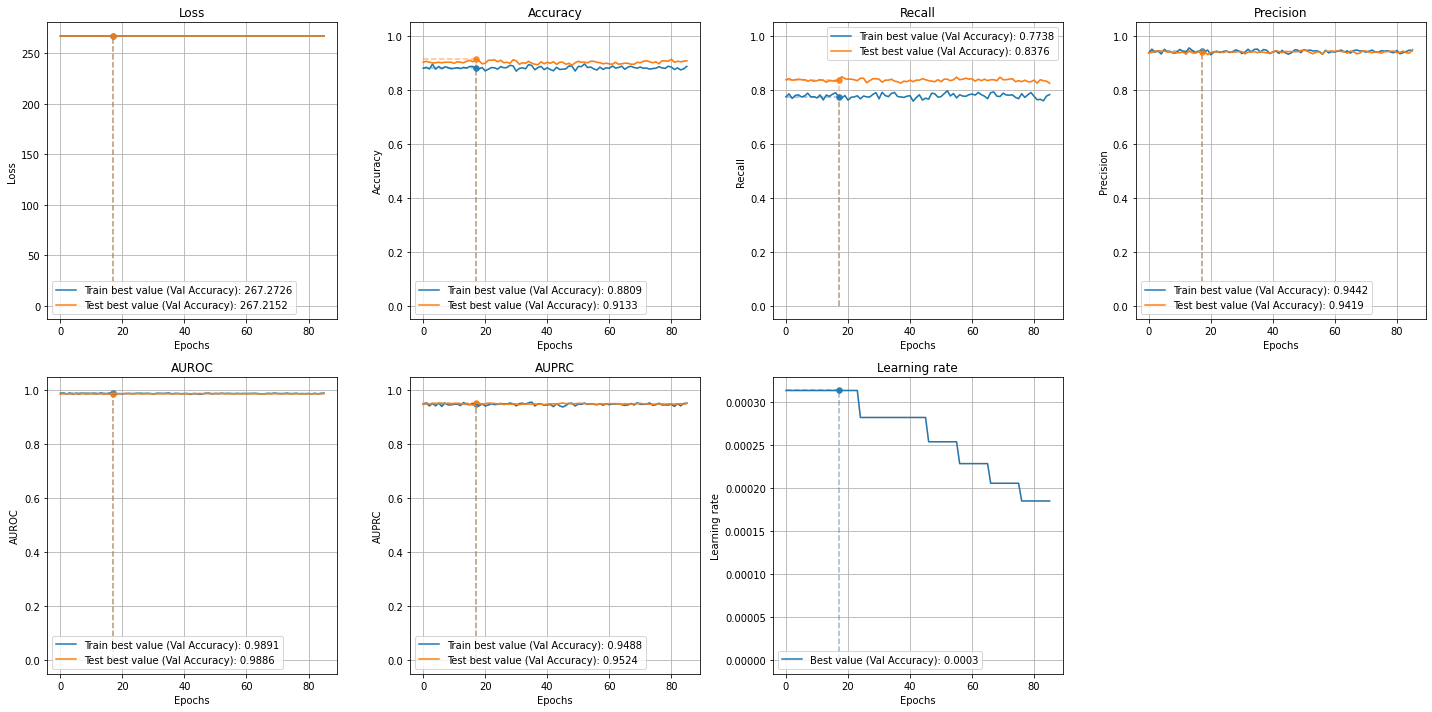

In [60]:
plot_history(history, monitor="val_accuracy")

In [61]:
nolan.evaluate(X_train, y_train, validation_data=(X_test, y_test))

5/5 [==============================] - 0s 18ms/step - AUPRC: 0.9522 - AUROC: 0.9887 - accuracy: 0.9077 - loss: 267.2151 - precision: 0.9418 - recall: 0.8358


({'loss': 267.1097412109375,
  'accuracy': 0.9515235424041748,
  'recall': 0.8947368264198303,
  'precision': 0.9768145084381104,
  'AUROC': 0.9982157349586487,
  'AUPRC': 0.9900014400482178},
 {'loss': 267.21514892578125,
  'accuracy': 0.9077490568161011,
  'recall': 0.8357933759689331,
  'precision': 0.9417879581451416,
  'AUROC': 0.9887043237686157,
  'AUPRC': 0.9521631598472595})

In [ ]:
nolan.trainable = True

In [ ]:
history = nolan.fit(
    X_train, y_train,
    #batch_size=128,
    max_neighbours=50,
    validation_data=(X_test, y_test),
)

In [ ]:
plot_history(history, monitor="val_accuracy")

In [ ]:
node_label_embedding = nolan.get_embedding_dataframe()

In [ ]:
visualization = GraphVisualization(graph, node_embedding_method="NoLaN")
visualization.fit_transform_nodes(node_label_embedding)
visualization.plot_node_types()
visualization.plot_node_degrees()

In [250]:
scatter_kwargs = dict(
    s=5,
    marker=".",
    alpha=1,
)

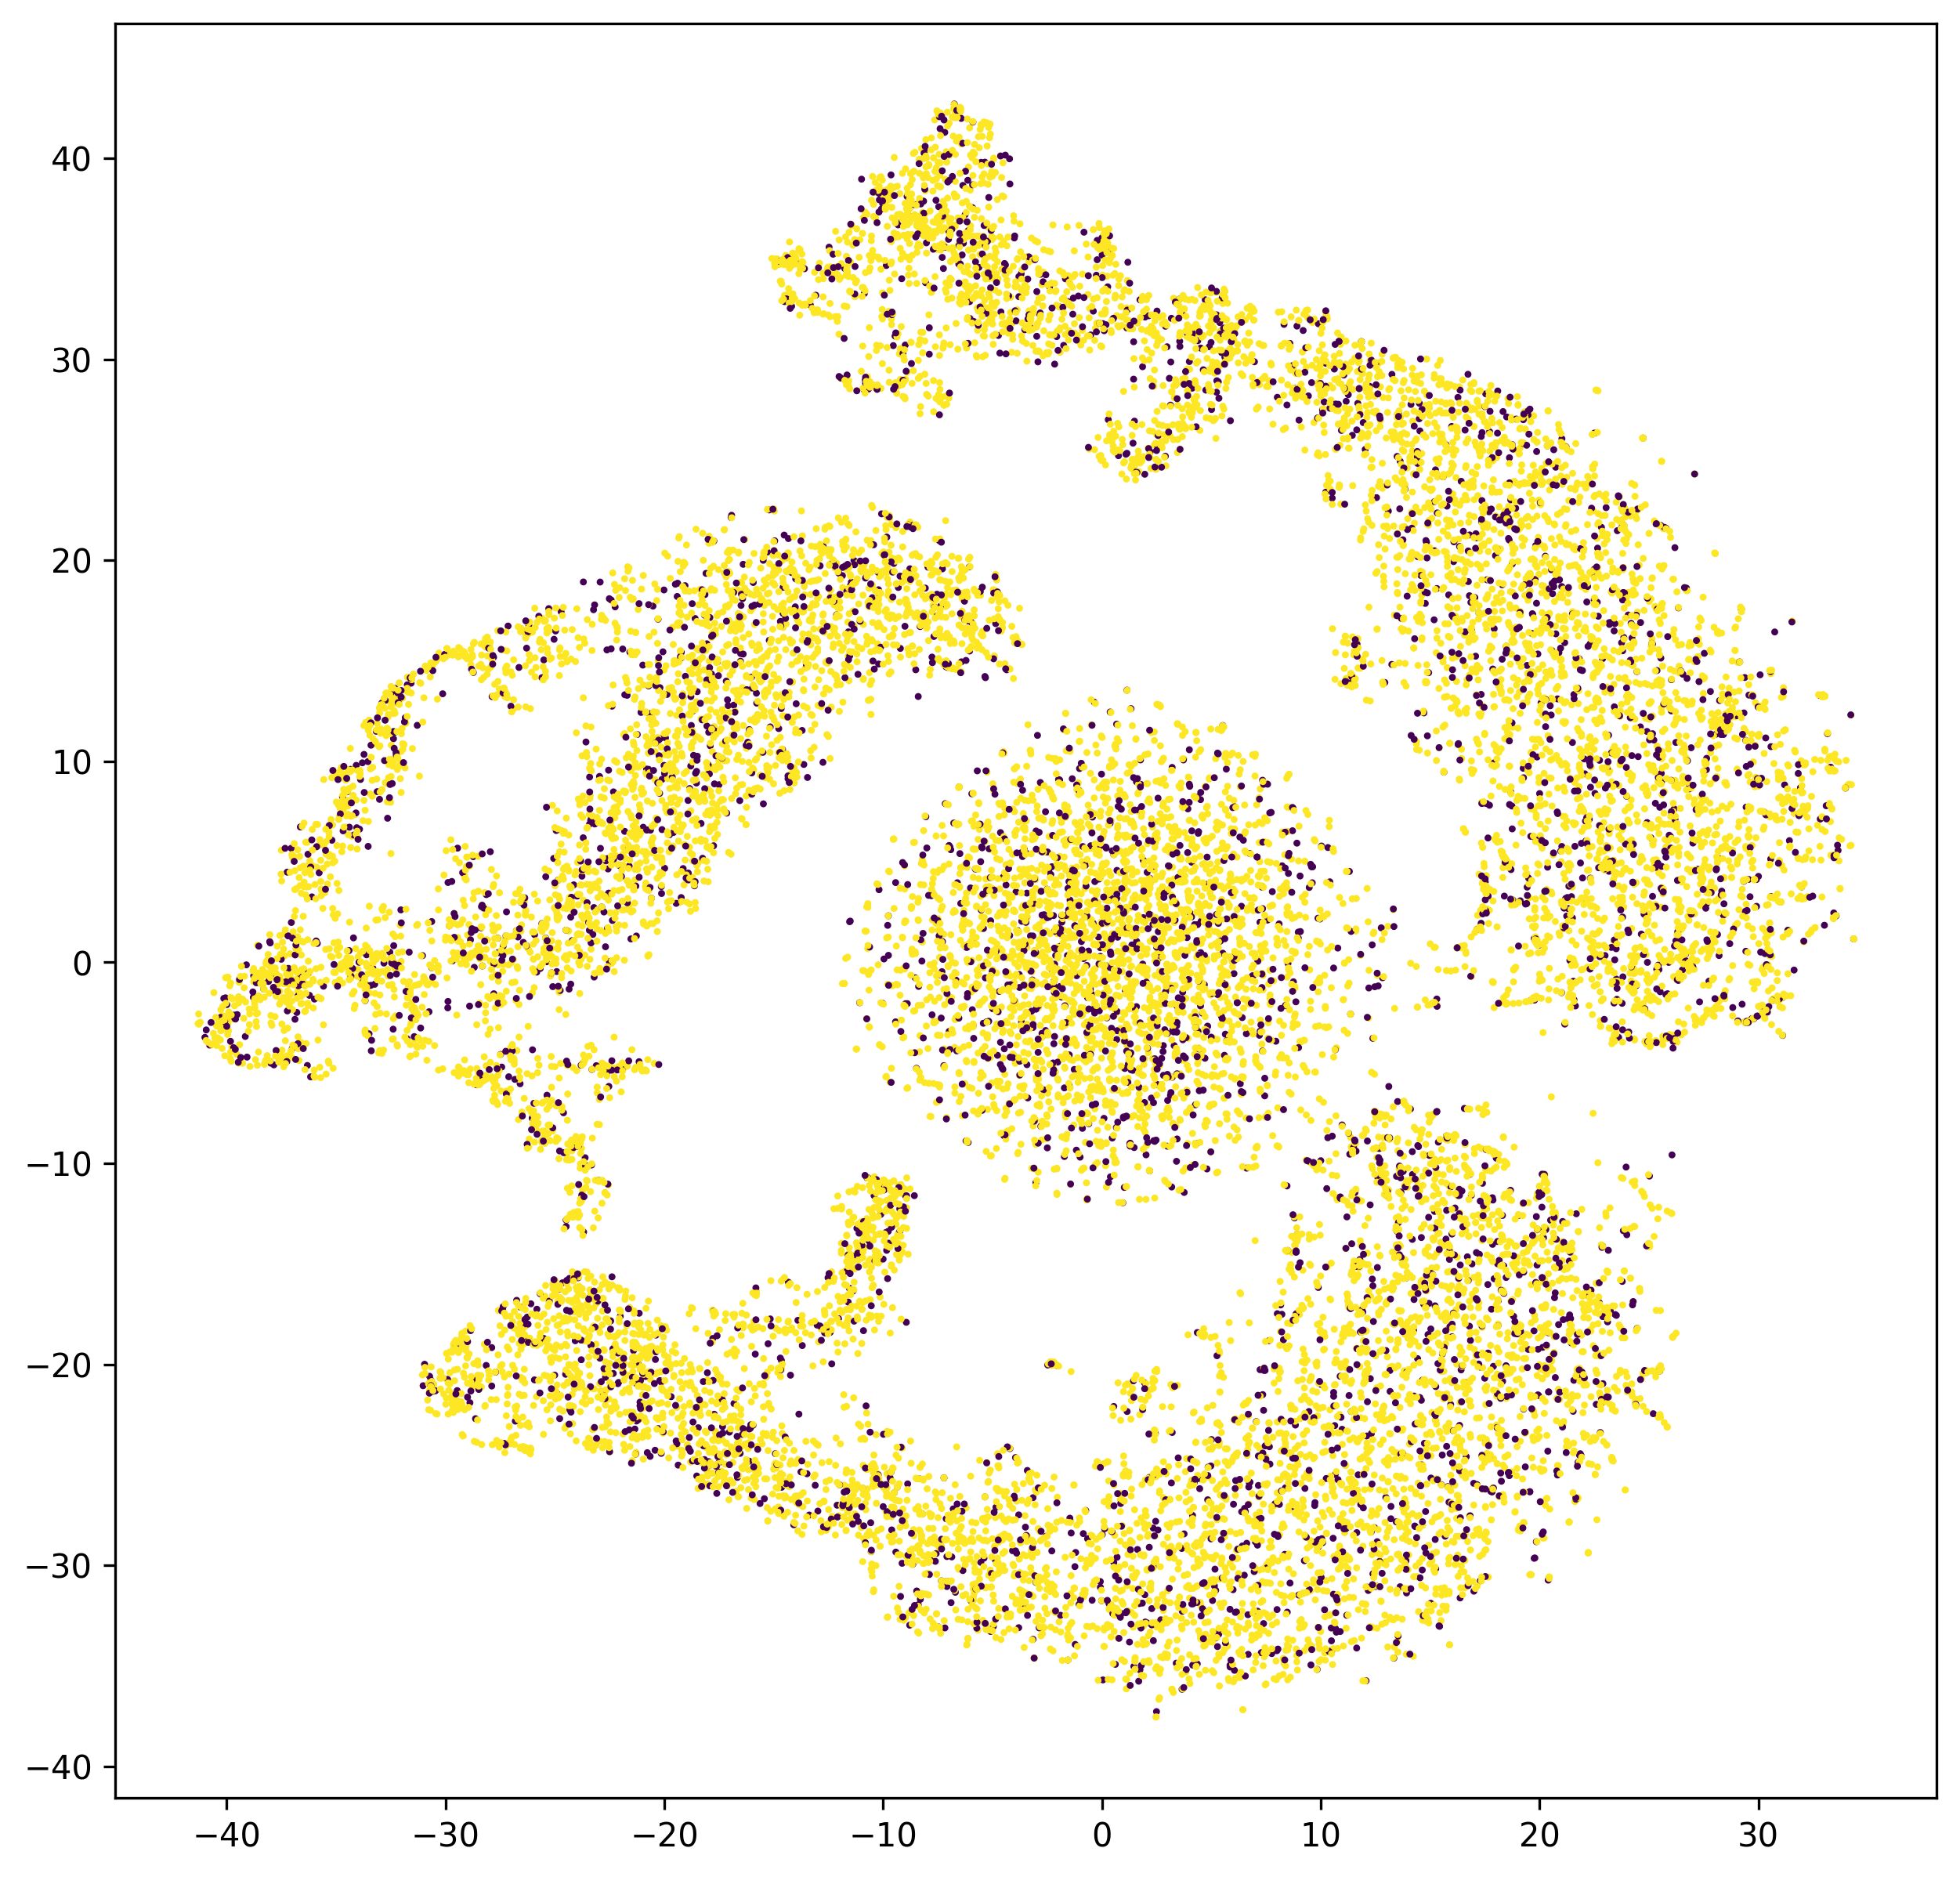

In [251]:
fig, axes = plt.subplots(figsize=(10, 10), dpi=300)

training = np.zeros(graph.get_nodes_number())
training[X_train] = 1

scatter = axes.scatter(
    *visualization._node_embedding.values.T,
    c=training,
    #cmap=plt.get_cmap("tab10"),
    **scatter_kwargs,
)

In [252]:
complete_data = pd.concat([
    node_label_embedding,
    node_embedding,
    words_features
], axis=1)

In [253]:
complete_data

,0,1,2,3,4,5,6,7,8,9,...,vitro,vivo,vs,week,weight,wherea,women,x,year,young
12187484,-0.014207,-0.000083,0.000084,0.000086,-0.000082,-0.000083,0.000087,0.000086,-0.000082,0.000085,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0
2344352,-0.088661,-0.000081,0.000085,-0.000040,0.000083,-0.000085,0.000080,0.000092,-0.000087,0.000088,...,0.000000,0.041603,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0
14654069,-0.007628,0.000086,-0.000083,-0.000083,0.000083,-0.000083,0.000085,-0.000084,-0.000083,0.000083,...,0.000000,0.000000,0.0,0.021497,0.045617,0.00000,0.0,0.0,0.000000,0.0
16443886,0.000082,-0.000085,-0.000084,-0.000084,-0.000084,-0.000085,-0.000084,-0.000085,0.000084,0.000084,...,0.000000,0.000000,0.0,0.000000,0.000000,0.02367,0.0,0.0,0.000000,0.0
2684155,-0.040711,-0.000093,0.000087,-0.000067,-0.000100,0.000095,-0.000045,-0.000095,-0.000066,0.000082,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17559889,0.008494,-0.000087,-0.000085,0.000085,0.000086,-0.000163,-0.000082,0.000086,0.000087,0.000088,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0
8792097,-0.000065,-0.000083,0.000084,-0.000084,-0.000084,0.000084,-0.000169,0.000084,0.000083,-0.000084,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0
17934141,0.004071,0.000085,-0.000088,-0.000085,0.000083,0.000087,0.000082,0.000084,0.000085,0.000085,...,0.160059,0.039893,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0
18673544,0.002506,0.000080,-0.000083,-0.000083,-0.000082,-0.000084,-0.000083,0.000083,0.000084,-0.000083,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.026013,0.0


In [254]:
from sklearn.preprocessing import RobustScaler

scaled = RobustScaler().fit_transform(complete_data)
scaled = pd.DataFrame(scaled, index=complete_data.index)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:title={'center':'Node degrees - PubMedDiabetes - SkipGram+NoLaN+Features'}>)

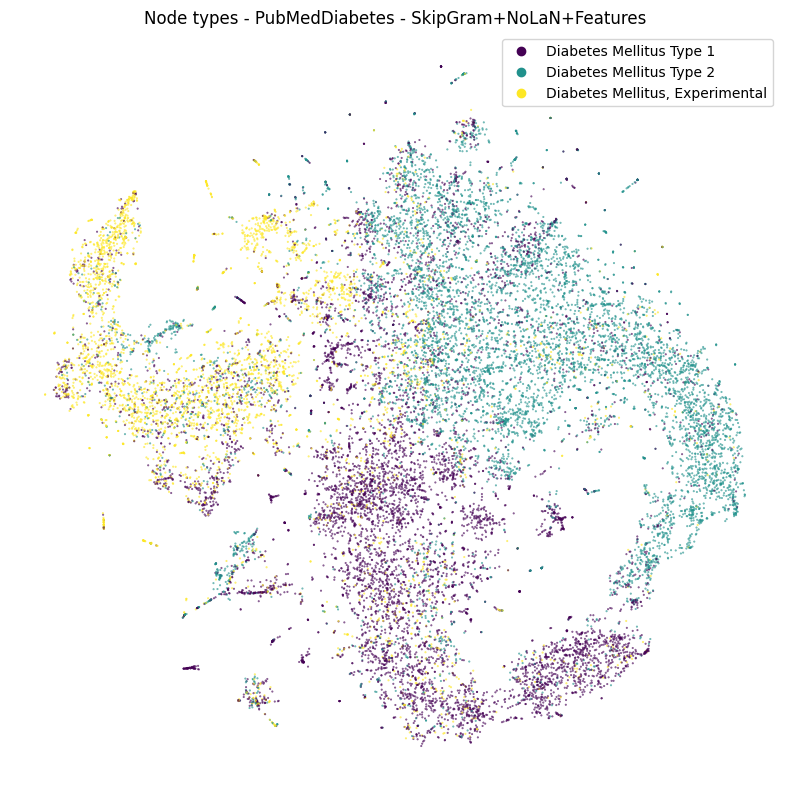

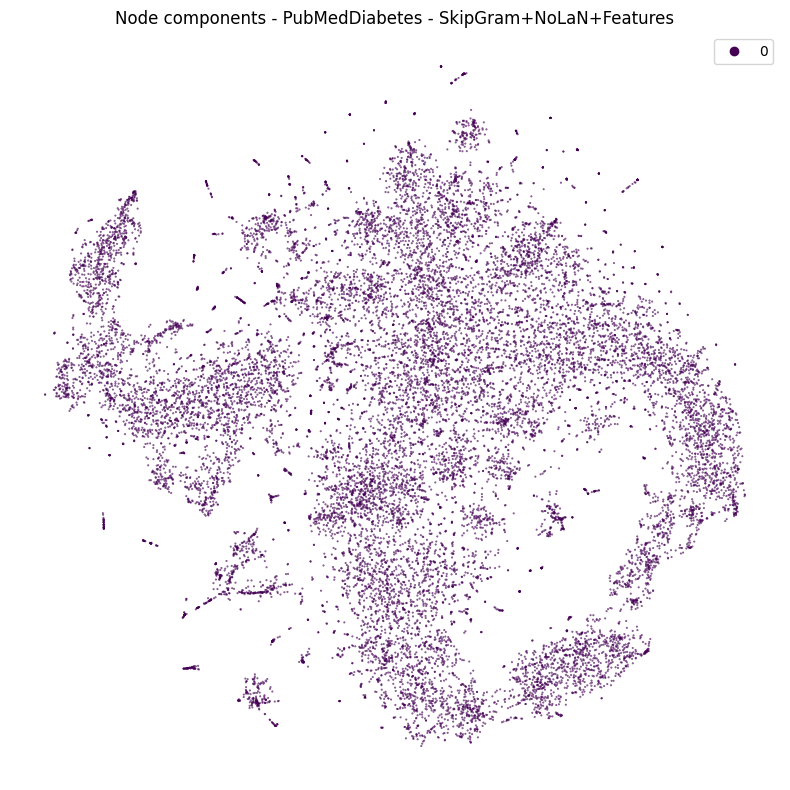

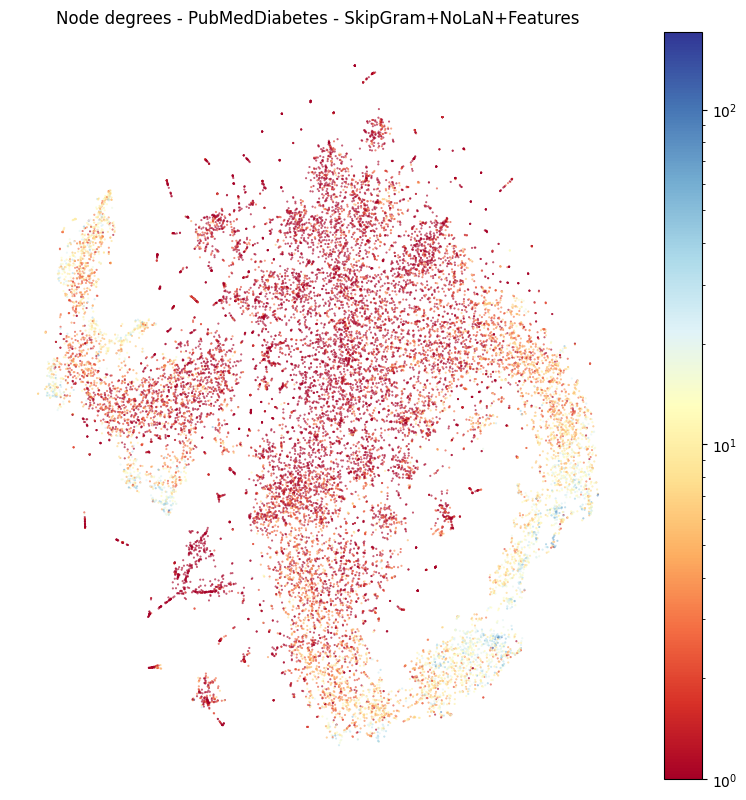

In [255]:
visualization = GraphVisualization(graph, node_embedding_method="SkipGram+NoLaN+Features")
visualization.fit_transform_nodes(scaled)
visualization.plot_node_types()
visualization.plot_connected_components()
visualization.plot_node_degrees()

In [256]:
from sklearn.preprocessing import RobustScaler

def normalize(features: List[pd.DataFrame])->List[pd.DataFrame]:
    normalizer = RobustScaler()
    return [
        pd.DataFrame(
            normalizer.fit_transform(df),
            index=df.index,
            columns=df.columns
        )
        for df in features
    ]


def split_train_test(features: List[pd.DataFrame], train_nodes: List[str], test_nodes:List[str])->List[pd.DataFrame]:
    return [
        (df.loc[train_nodes], df.loc[test_nodes])
        for df in normalize(features)
    ]

In [257]:
node_names = np.array(graph.get_node_names())

(
    (node_embedding_train, node_embedding_test),
    (label_backprop_train, label_backprop_test),
    (node_features_train, node_features_test),
) = split_train_test(
    (node_embedding, node_label_embedding, words_features),
    node_names[X_train], node_names[X_test]
)

graph_name = graph.get_name()

node_embedding_train.to_csv("node_embedding_train_{}.csv.xz".format(graph_name))
label_backprop_train.to_csv("label_embedding_train_{}.csv.xz".format(graph_name))
node_features_train.to_csv("features_embedding_train_{}.csv.xz".format(graph_name))
node_embedding_test.to_csv("node_embedding_test_{}.csv.xz".format(graph_name))
label_backprop_test.to_csv("label_embedding_test_{}.csv.xz".format(graph_name))
node_features_test.to_csv("features_embedding_test_{}.csv.xz".format(graph_name))
pd.DataFrame(
    y_train,
    index=node_names[X_train]
).to_csv("train_y_{}.csv.xz".format(graph_name))
pd.DataFrame(
    y_test,
    index=node_names[X_test]
).to_csv("test_y_{}.csv.xz".format(graph_name))